# Установка Pyspark. Pyspark используется для распределенных вычислений [4]

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Обновляем библиотеки networkx и scipy чтобы была их совместимость
# Разные версии библиотек могут быть несовместимы
!pip install --upgrade scipy networkx

# Импортируем библиотеки
import networkx as nx
import matplotlib.pyplot as plt

# Pandas в данном случае использую, для более удобного преобразования входных данных в pyspark
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Чтобы каждый раз не подгружать данныее их лучше всеко скачать. При этом разместив данные на Гугл Диск
# Скачиваем данные в колаб
! gdown --id 19Cbp1rMfuifpFlZCyxZjl-lWDnG1nvgQ

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19Cbp1rMfuifpFlZCyxZjl-lWDnG1nvgQ
To: /content/graph1666.txt
100% 20.5k/20.5k [00:00<00:00, 16.0MB/s]


In [ ]:
# Список вершин и ребер в формате dataframe
df_edge = pd.read_csv('graph1666.txt', sep=' ')
df_edge.head(3)

,vertices,edges
0,1,488
1,13,49
2,14,19


In [ ]:
# Скачиваем данные список ребер в удобочитаемом виде
! gdown --id 1RRxPHdIfXBMB_sWmji-hAXvsiYcowP9B

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RRxPHdIfXBMB_sWmji-hAXvsiYcowP9B
To: /content/edges_list.txt
100% 20.5k/20.5k [00:00<00:00, 19.2MB/s]


In [ ]:
# Создадим граф и отобразим его
g = nx.read_edgelist('edges_list.txt')

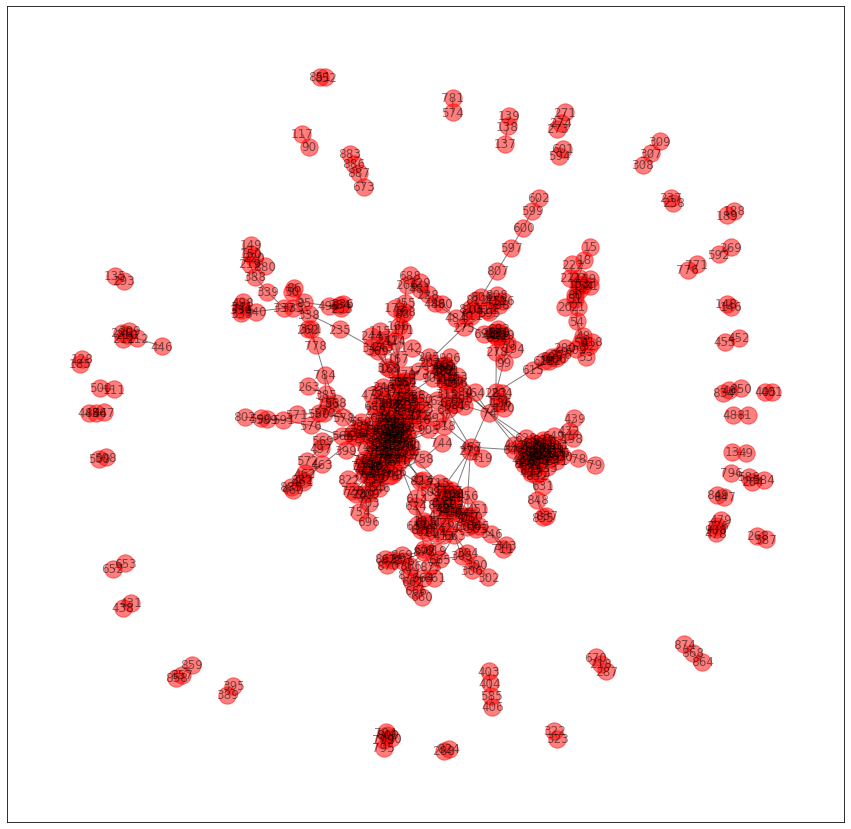

In [ ]:
# Выведем граф
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(g, with_labels=True, alpha=0.5, node_color='red')
plt.show()

In [ ]:
# Список пар ребер в виде кортежа
list_edges = list(df_edge[['vertices', 'edges']].itertuples(index=False, name=None))

In [ ]:
# Список вершин в иде кортежей
list_ver = []
for x in df_edge['vertices'].unique():
    list_ver.append((x,))

In [ ]:
import pyspark
from pyspark import SparkContext

from pyspark.sql import SQLContext
# Создаем паралельную коллекцию. Это позволяет spark распределять данные между несколькими узлами вместо одного
sc = SparkContext.getOrCreate()
# После того, как произойдёт загрузка данных, ребра и вершины будут записаны записаны в виде специального распределённого набора данных RDD (Resilient Distributed Dataset)
edges = sc.parallelize(list_edges)
vectices = sc.parallelize(list_ver)

## Алгоритм NodeIterator

Алгоритм работает путем поворота вокруг каждого узла, а затем проверяет существует ли ребро, которое может образовать треугольник. Отметим, что каждый треугольник {u, v, w} считается 6 раз (один раз как {u, v, w}, {u, w, v}, {v, u, w}, {v, w, u}, {w, u, v} и {w, v, u}).

## Реализация алгоритма выглядит следующим образом:
1. Генерация возможных путей длины 2 на каждой вершине
2. Проверяем, какой из путей длины два, созданных в шаге 1, может быть закрыт ребром в графе, тем самым получая треугольник и подсчитаем треугольники соответственно.

Алгоритм выглядит следующим образом

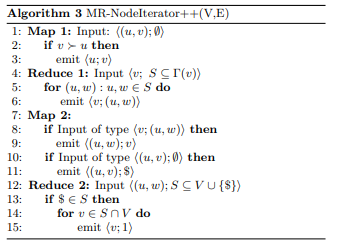

In [ ]:
# Перебор вершин
def findTriangles(edges):

    def preprocessEdges(x):
        # Упорядочим вершины
        if x[0]<x[1]:
            return (x[0],x[1])
        else:
            return (x[1],x[0])


    edges = edges.map(preprocessEdges)


    def mapper1(x):
      # На этапе map входные данные обрабатываются по одному кортежу за раз.
      # Это позволяет обрабатывать разные кортежи на разных машинах
      # и создает возможность для массового распараллеливания.'''

        if x[0]<x[1]:
            return (x[0],[x[1]])
        else:
            return (x[1],[x[0]])
    output_map1 = (edges.map(mapper1).filter(lambda x:x!=None)
        .reduceByKey(lambda x,y:x+y))


    def reducer1(x):
        output = []
        for a in range(0,len(x[1])):
            for b in range(a+1,len(x[1])):
                output.append(((x[1][a],x[1][b]),[x[0]]))
        return output

    # Применим функцию трансформации к otput_map1
    output_reducer1 = output_map1.flatMap(reducer1)
    # map используется для применения лямбды функции
    output_reducer2 = edges.map(lambda x: ((x[0],x[1]),["*"]))
    # Объеденим реузльтаты output_reducer1  и output_reducer2
    output_reducer2 = output_reducer2.union(output_reducer1)
    output = output_reducer2.reduceByKey(lambda x,y:x+y).collect()

    def generateTriplets(x):
        # Создаем список, в который будем добавлять треугольники
        output = []
        # Проходим циклом по списку ребер
        for tupples in x:
            vertex_list = tupples[1]
            if "*" in vertex_list and len(vertex_list)!=1:
              # Собираем множество вершин, которые имеют треугольники
                vertex_list = set(vertex_list)-{"*"}
                for vertex in vertex_list:
                    output.append((tupples[0][0],tupples[0][1],vertex))

        return output

    return len(generateTriplets(output))

In [ ]:
def driverNodeIteratorAlgorithm(edges):
    return findTriangles(edges)

In [ ]:
#Driver program to count the triangles
output1 = driverNodeIteratorAlgorithm(edges)
print("Количество треугольников:\t",output1)

Количество треугольников:	 883


# Алгоритм разбиения ( Partition Algorithm)

Алгоритм работает путем разбиения графов на перекрывающиеся подмножества таким образом, чтобы каждый треугольник присутствовал хотя бы в одном из подмножеств. Учитывая такое разбиение, мы можем использовать любой последовательный алгоритм подсчета треугольников в качестве черного ящика на каждом разбиении, а затем просто объединить результаты.

Алгоритм выполняет взвешенный подсчет количества треугольников в каждом подграфе G. Веса корректируют тот факт, что треугольник может встречаться во многих подграфах. Код MapReduce для этапа разбиения представлен в алгоритме 4 [1].

Воспользуемся Лемой 4 [1].

Если вершины отображены на два разных разбиения, например, $h(x) = h(w)$, но $h(x) \neq h(y)$, то треугольник появится $ρ-2$ раза. Например, предположим, что $ρ = 4$, $h(x) = h(y) = 1$ и $h(z) = 3$.

Алгоритм выглядит следующим образом:

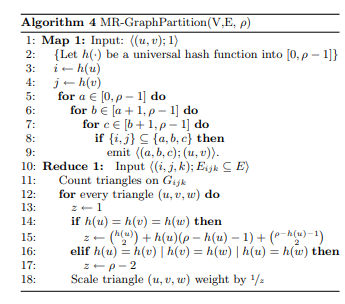

In [ ]:
#  MapReduce
def driverPartitionAlgorithm(edges):
    p = 4 # параметр [1]

    def mapper(x):
        i = int(x[0]) % p
        j = int(x[1]) % p

        output = []

        # Алгоритм 4 [1]
        for a in range(0,p):
            for b in range(a+1,p):
                for c in range(b+1,p):
                    if {i,j}.issubset({a,b,c}):
                        (output.append((str(a)+" "+str(b)+" "+str(c),
                                        [(x[0],x[1])])))
        return output
    mapper_output = (edges.flatMap(lambda x:mapper(x))
        .reduceByKey(lambda x,y: x+y))
    # Алгоритм 4 [1]
    def reducer(edge_list):
        no_triangles = 0

     # Алгоритм 4 [1]
        def findTriangles(edges):
            import networkx as nx
            G=nx.Graph()
            for x in edges:
                G.add_edge(x[0],x[1])
            result=[]
            done=set()
            for n in G:
                done.add(n)
                nbrdone=set()
                nbrs=set(G[n])
                for nbr in nbrs:
                    if nbr in done:
                        continue
                    nbrdone.add(nbr)
                    for both in nbrs.intersection(G[nbr]):
                        if both in done or both in nbrdone:
                            continue
                        result.append( (n,nbr,both) )
            return result

        triangles = findTriangles(edge_list)


        def weightedCount(x):
            u = int(x[0]) % p
            v = int(x[1]) % p
            w = int(x[2]) % p

            z = 1
            if u==v and v==w:
                z = (u*(u-1)/2) + u*(p-u-1) + ((p-u-1)*(p-u-2)/2)
            elif u==v or v==w or u==w:
                z = p-2
            z = 1/z
            #return (str(x[0])+" "+str(x[1])+" "+str(x[2]),z)
            return z

        for tri in triangles:
            no_triangles +=  weightedCount(tri)
        return ("*",no_triangles)

    reducer_output = mapper_output.map(lambda x:reducer(x[1]))
    return reducer_output.values().sum()

In [ ]:
#Подсчет треугольников алгоритмом частичного разбиения
output2 = driverPartitionAlgorithm(edges)
print("Количество треугольников:\t",int(output2))

Количество треугольников:	 883


In [ ]:
if output1 == output2:
    print("Перебор вершин и алгоритм частичного разбиения MAPREDUCE показывают одинаковое количество треугольников")

In [ ]:
# Замер времени выполнения алгоритмов
import time
currentMilliTime = lambda: int(round(time.time() * 1000))

t1 = currentMilliTime()
driverNodeIteratorAlgorithm(edges)
t2 = currentMilliTime()
time1 = t2-t1

t1 = currentMilliTime()
driverPartitionAlgorithm(edges)
t2 = currentMilliTime()
time2 = t2-t1

In [ ]:
print("Время подсчет треугольников (клик) перебором вершин: \t {0} милисекунд.".format(time1))
print("Время выполнения алгоритма частичного разбиения \t\t {0} милисекунд.".format(time2))

Время подсчет треугольников (клик) перебором вершин: 	 1020 милисекунд.
Время выполнения алгоритма частичного разбиения 		 615 милисекунд.


Как видим алгоритм частичного разбиения MapReduce по скорости превосходит почти в два раза перебор вершин. Общее количество клик получилось `883`. В качестве данных были взяты данная выборка пользователей, спаршенных по направлению "прикладная математика и информатика"

# Расчет треугольников на случайном графе (Число вершин = 10, число ребер=20) [5]


Матрица смежности
0 8 2 9 1
1 2 4 9 3
2 7 6
3 9 8 7
4 7 6 8
5 8 9
6
7 9 8
8
9


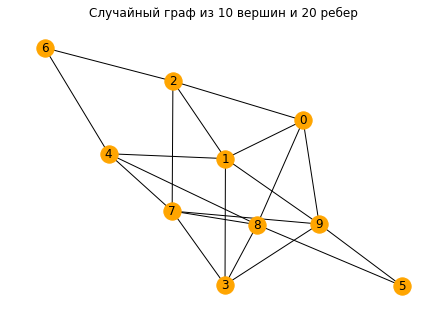

In [ ]:


n = 10  # 10 вершин
m = 20  # 20 ребер
seed = 20160  # заморозим счетчик


G = nx.gnm_random_graph(n, m, seed=seed)


print()
print("Матрица смежности")
for line in nx.generate_adjlist(G):
    print(line)

pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos=pos, with_labels=True, node_color='orange')
plt.title('Cлучайный граф из 10 вершин и 20 ребер')
plt.show()

In [ ]:
# Сохраним список ребер
nx.write_edgelist(G, "testedgelist.txt")

In [ ]:
# Сделаем из списка датафрейм и некоторые преобразования для удобства
df1 = pd.read_csv('testedgelist.txt', sep=' ',  names=['vertices', 'edges'], header=None).reset_index()

df1['edges'] = df1['vertices']
df1['vertices'] = df1['index']

In [ ]:
# Список вершин (список кортежей)
list_edges_test = list(df1[['vertices', 'edges']].itertuples(index=False, name=None))


In [ ]:
# Список вершин добавим в список для преобразования в формат pyspark
list_ver_test = []
for x in df1['vertices'].unique():
    list_ver_test.append((x,))

In [ ]:
sc = SparkContext.getOrCreate()
edges_test = sc.parallelize(list_edges_test)
vectices_test = sc.parallelize(list_ver_test)

In [ ]:
#Driver program to count the triangles
output3 = driverPartitionAlgorithm(edges_test)
print("Количество треугольников:\t",int(output3))

Количество треугольников:	 6


In [ ]:
# Создадим объект со всеми кликами
all_cliques= nx.enumerate_all_cliques(G)

In [ ]:
# Создадим список со всеми треугольниками из списка ребер
triad_cliques=[x for x in all_cliques if len(x)==3 ]

In [ ]:
# Выведем все треугольники
triad_cliques

[[0, 1, 2], [0, 1, 9], [1, 3, 9], [3, 7, 8], [3, 7, 9], [4, 7, 8]]

In [ ]:
# Посчитаем количество треугольников
outputx = len(triad_cliques)
print(f'Количество треугольников из клик: {outputx}')

Количество треугольников из клик: 6


In [ ]:
# Проверим условия
print(f'Количество треугольников алгоритм частичного разбиения MapReduce: {output3}')
print(f'Количество треугольников из клик: {outputx}')
print()
if output3 == outputx:
  print('Число треугольников совпадает расчет выполнен верно')
else:
  print('Проверьте алгоритм')

Количество треугольников алгоритм частичного разбиения MapReduce: 6.0
Количество треугольников из клик: 6

Число треугольников совпадает расчет выполнен верно


### Напишем функцию подсчета количества треугольников методами библиотеки NetworkX не используя распределенных вычислений

In [ ]:
def count_triangles(G):
  all_cliques= nx.enumerate_all_cliques(G)
  triad_cliques=[x for x in all_cliques if len(x)==3 ]

  return len(triad_cliques)

In [ ]:
# Считываем наш граф
G1 = nx.read_edgelist('edges_list.txt')

In [ ]:
n_triangles = count_triangles(G1)

print(f'Количество треугольников (встроенные методы NetworkX) составляет {n_triangles}')

Количество треугольников (встроенные методы NetworkX) составляет 883


## Заключение

В ходе выполнения работы были исследованы алгоритмы подсчета треугольников в графе на основе распределенных вычислений MapReduce. Элементарная вычислительная задача в данной модели состоит из двух шагов:
Map и Reduce. Вычислительные элементы, реализующие эти шаги, называются, соответственно, маппер (mapper) и редьюсер (reducer). Особенностью распределенных вычислений является то, что Одновременно над одной задачей может работать большое количество мапперов и редьюсеров распределённых по машинам кластера.

В работе приведены два алгоритма на основе распределенных вычислений это перебор вершин и распределенный алгоритм.

Правильность расчетов была проверена на случайном графе в сравнении со встроенными методами библиотеки NetworkX

## Список использованных источников:
1. Counting Triangles and the Curse of the Last Reducer / Siddharth Suri, Sergei Vassilvitskii ., https://github.com/akanshu22/Triangle-Counting-Problem-in-Apache-Spark/blob/master/paperontrianglecounting.pdf

2. Юре Лесковец, Ананд Раджараман, Джеффри Д. Ульман
Анализ больших наборов данных. / Пер. с англ. Слинкин А. А. – М.: ДМК
Пресс, 2016. – 498 с.: ил

3. Исследование и разработка распределённых
алгоритмов для поиска сообществ пользователей в
социальных сетях., Рябов С.В., Московский государственный университет имени М.В.
Ломоносова., 2012 г

4. https://spark.apache.org/docs/latest/api/python/

5. https://networkx.org/

6.